# Predicting Pet Insurance Claims - Model Tuning and Predictions
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in USD) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* Continue model evaluation and tuning
* Select the best model balancing performance and compute time
* Make predictions against the test data
* Summarize the results


## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import __version__ as sklearn_version

import datetime
import os
import pickle
from library.sb_utils import save_file

### 2.2 Data and Initial Modeling Results
We ended preprocessing and initial modeling with our training and test sets and some initial results. In order to continue on enhancing our model, we need to load in our training and test data as a first step. 

#### 2.2.1 Data Load
Let's take a look at the shape of our training and test sets and get a preview of our test data.

In [2]:
# Read in the training and test sets
X_train = pd.read_csv('../data/X_train.csv', index_col=0)
y_train = np.genfromtxt('../data/y_train.csv', delimiter=',')
X_test = pd.read_csv('../data/X_test.csv', index_col=0)
y_test = np.genfromtxt('../data/y_test.csv', delimiter=',')

# Preview the shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 12)
(10000, 12)
(40000,)
(10000,)


In [3]:
# Preview the training data
X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
AgeYr1,3,0,0,1,2,0,6,6
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,76.25,0.0,6010.88,303.15,0.0,701.6,431.57,0.0
AvgClaimsYr1,76.25,0.0,546.443636,151.575,0.0,701.6,215.785,0.0
NumClaimsYr1,1,0,11,2,0,1,2,0
BreedAvgTotalClaims,663.502526,540.515378,705.72864,705.72864,663.502526,925.434405,395.718466,1509.175333
BreedAvgNumClaims,1.491045,1.627294,1.766242,1.766242,1.491045,1.875611,0.871485,2.552941
BreedAvgClaimAmt,196.601991,159.645266,198.844913,198.844913,196.601991,240.294459,137.970879,315.759532
AgeYr1AvgTotalClaims,722.652663,902.942389,902.942389,699.071121,619.496248,902.942389,449.891932,904.086963


#### 2.2.2 Initial Modeling Results
In the previous notebook, we completed some initial modeling including the following:
* Established a baseline using `DummyRegressor()` with predictions equivalent to the mean value of the target 
* Created a simple liner model using `LinearRegressor()` and default settings
* Enhanced our simple linear model by incorporating feature selection and making predictions using the best 'k' features

Using the linear model with feature selection, we managed to improve upon the baseline model by **~9%**, or over **\$90** per customer. Given the size of the total customer base (~65-75 million pets), this represents a significant total value that could be realized by factoring model predictions into policy premium and deductible amounts.

In this notebook, we'll continue tuning our model and evaluating additional modeling approaches to see if we can improve upon the initial result. Following this evaluation, we will select our final model and make predictions on our test set to generate final results. Our best model so far is using a **simple linear regression model with feature selection**. This resulted in a mean absolute error of **~\\$930**. So there could be a lot of room for improvement if we can find a model that better suits our data.

#### 2.2.3 Data Preprocessing
In our previous notebook, we also created a simple preprocessor to handle our remaining category data in the Species column. We'll recreate that here for use in our model pipelines throughout.

In [4]:
# Create a preprocessor to encode the remaining categorical column
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['Species']), remainder='passthrough')

## 3 Lasso Regression
For our first modeling technique, we'll utilize **Lasso Regression**. Lasso can be useful in cases where only a few of the features are actually influencing the predictions. As observed in the previous notebook, our situation is similar here. Although we saw 9 features selected as a result of using the 'best k' features, only 2 or 3 appeared to have significant coefficient values with the remainder very close to zero.

For Lasso, we'll start off by utilizing a basic version of the algorithm with no tuning and then we'll utilize grid search to see if we can tune the results further. 

### 3.1 Simple Lasso Regression Model

In [5]:
# Make pipeline, cross validate and get results
pipe = make_pipeline(preprocessor, Lasso())
cv_results = cross_validate(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
score_mean = -1 * round(np.mean(cv_results['test_score']), 2)
print("mean test score (mae): " + str(score_mean))

mean test score (mae): 930.28


So utilizing Lasso regression with default settings, we've managed to improve our MAE by about 0.07. Overall, not great. Let's see what we can do to improve on this by applying grid search and searching over a range of parameter values.

### 3.2 Lasso Regression with GridSearchCV

In [9]:
# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),('regressor', Lasso())])

# Establish the parameter grid
param_grid = {'regressor__alpha': [0.1, 1, 5, 10], 'regressor__fit_intercept': [True, False],
              'regressor__normalize': [True, False]}

# Instantiate the grid search and fit the model
Lasso_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
Lasso_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 1, 5, 10],
                         'regressor__fit_intercept': [True, False],
                         'regressor__normalize': [True, False]},
             scoring='neg_mean_absolute_error')

In [10]:
# Print best test score
best_score = -1 * round(np.max(Lasso_GS.cv_results_['mean_test_score']), 2)
print("best score (mae): " + str(best_score))

best score (mae): 930.18


In [11]:
Lasso_GS.best_params_

{'regressor__alpha': 5,
 'regressor__fit_intercept': True,
 'regressor__normalize': False}

Again, we see a very modest improvement in the Lasso regression results by adding parameter tuning. We could continue tweaking our parameter grid, but given the very small amount of improvement so far, it seems unlikely that we will see a substantial improvement by continuing to fine tune the model.

Rather than focusing more time on Lasso, let's move on to evaluate another model that may be a good fit in this scenario, **Gradient Boosting**.


## 4 Gradient Boosting
Up to this point, we seem to be hitting a wall when it comes to model performance gains with our **MAE values plateauing around 930**. 

One reason for this could very well be that our data simply doesn't fit well into a linear model. As observed throughout this project, none of our features are regularly distributed, many have severe outlier values, and our target (i.e., Insurance Claims Amount) is mostly random in nature and as a result, difficult to predict with precision.

Given this fact, it stands to reason that we need a model such as Gradient Boosting that can perform well with unbalanced data. Gradient Boosting is an ensemble technique that combines a set of weak learners to improve prediction accuracy. To achieve this, each iteration *learns* from the previous iteration and the model results are based on the weighted predictions of all iterations.

We'll start with a simple model and build from there.

### 4.1 Simple Gradient Boosting Model

In [12]:
# Make pipeline, cross-validate, and get results
pipe = make_pipeline(preprocessor, GradientBoostingRegressor())
cv_results = cross_validate(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
score_mean = -1 * round(np.mean(cv_results['test_score']), 2)
print("mean test score (mae): " + str(score_mean))

mean test score (mae): 932.45


Using a simple Gradient Boosting model, we see our predictive accuracy actually got worse. That's not too surprising considering we made no effort to tune the model, but it might be an early indication that we won't see much improvement over and above our current best score of ~930. 

### 4.2 Gradient Boosting - Tuning N_estimators and learning_rate

As a next step, let's start by tuning 'n_estimators' (the number of boosting stages) and 'learning_rate' (which shrinks the contribution of each tree. There is typically a tradeoff between these two parameters and so finding the right balance will help provide us with a good foundation to continue the tuning process.

For this tuning step, we'll implement a grid search using a range of values for each of the two parameters mentioned above, and we'll stay with the default values for all other parameters for now. Afterwards, we can see which pair of values gave us the best performance and also plot the overall results.

In [13]:
# Instantiate the regressor model
regressor = GradientBoostingRegressor(random_state=23)

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', regressor)
                ])

# Establish the parameter grid
param_grid = { 'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
               'regressor__n_estimators': range(10, 110, 10),
              }

# Instantiate the grid search and fit the model
GB_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
GB_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=23))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1,
                                                      0.2],
                         'regressor__n_estimators': range(10, 110, 10)},
             scoring='neg_mean_absolute_error')

In [14]:
# Print best test score
best_score = -1 * round(np.max(GB_GS.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score) + "\n")

# Print best params from grid search
print("Best Params:"), GB_GS.best_params_

Best Score (MAE): 931.92

Best Params:


(None, {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 80})

With some basic tuning, we managed to see a modest improvement, but we are still hovering around the ~930 range. We've also significantly increased our compute time and the result is still not as good as what we observed using Lasso. 

Before moving on with more advanced tuning, let's plot the results to get a better feel for how these two parameters are affecting the scores. We can create a function for this that will come in handy as we continue tuning our model.

In [15]:
# Create a function for plotting the 
def plot_grid_search_results(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    # Create a numpy array of lists containing mean test scores for each combo of params
    score_means = cv_results['mean_test_score']
    n = len(grid_param_2)
    score_means_list = []
    for i in range(n):
        scores_by_param = score_means[i::n]
        score_means_list.append(scores_by_param)
    score_means_list = np.array(score_means_list)
    
    # Plot grid search scores
    _, ax = plt.subplots(1,1, figsize=(12, 6))

    # Param_1 is the X-axis, Param 2 is represented as a different color line on the plot
    for idx, val in enumerate(grid_param_2):
        plt.plot(grid_param_1, score_means_list[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    plt.suptitle("Grid Search Scores", y=0.95, fontsize=14)
    plt.xlabel(name_param_1, fontsize=12) 
    plt.ylabel('CV Average Score', fontsize=12) 
    plt.legend(loc="best", fontsize=12, bbox_to_anchor=(1, 1.02))

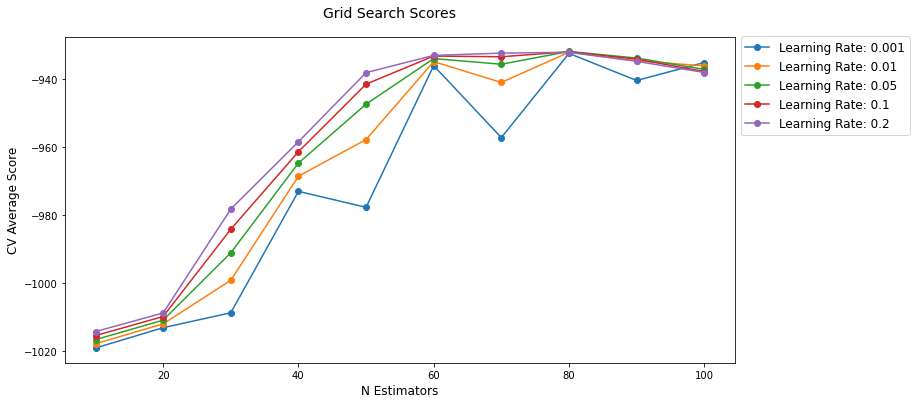

In [16]:
# Plot the results
plot_grid_search_results(GB_GS.cv_results_, 
                         GB_GS.param_grid['regressor__n_estimators'],
                         GB_GS.param_grid['regressor__learning_rate'], 
                         'N Estimators', 'Learning Rate')

We can see above, that our best set of parameters for n_estimators and learning_rate are 80 and 0.1, respectively. These are pretty close the the model defaults (i.e., 100, 0.1), so it feels appropriate that we didn't see much of an improvement in our model score. Interestingly, based on the plot above, it appears that the scores for all learning rates converge at a value of 80 for 'n_estimators'. This definitely helps to build confidence that we've landed on the right value for this parameter. 

### 4.3 Gradient Boosting - Tuning loss and alpha

Before we look at tuning our model for the tree structure-related parameters (max_depth, num_samples_split, etc.) let's focus on tuning the 'loss' and 'alpha' parameters in a similar fashion to n_estimators and learning rate. Up to now, all of our models have been focused on either MSE or MAE for a loss function and this may not be the best approach for our data.

The default for loss is 'squared_error', but for this round of testing, we'll test with the 'huber' and 'quantile' loss functions. Both huber and quantile tend to be more robust against outliers in the data and as observed in EDA, our data is heavy on outlier values. This pairs nicely with alpha since alpha is used to more finely tune the selected loss function. For 'alpha', 0.9 is the default value. In addition to this, we'll test a range of values down to 0.1 and then plot the results.

In [17]:
# Instantiate the regressor model
regressor = GradientBoostingRegressor(n_estimators=80, random_state=23)

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', regressor)
                ])

# Establish the parameter grid
param_grid = { 'regressor__loss': ['huber', 'quantile'],
               'regressor__alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
              }

# Instantiate the grid search and fit the model
GB_GS = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
GB_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Species'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(n_estimators=80,
                                                                  random_state=23))]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'regressor__loss': ['huber', 'quantile']},
             scoring='neg_mean_absolute_error')

In [18]:
# Print best test score
best_score = -1 * round(np.max(GB_GS.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score) + "\n")

# Print best params from grid search
print("Best Params:"), GB_GS.best_params_

Best Score (MAE): 677.75

Best Params:


(None, {'regressor__alpha': 0.5, 'regressor__loss': 'quantile'})

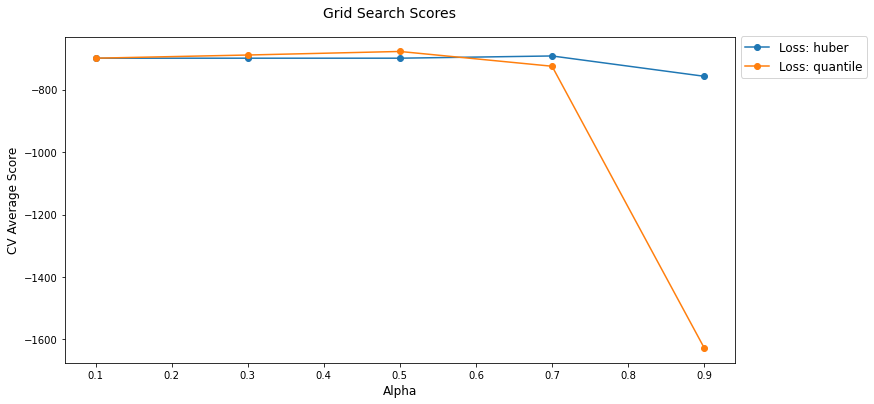

In [19]:
# Plot the results
plot_grid_search_results(GB_GS.cv_results_, 
                         GB_GS.param_grid['regressor__alpha'],
                         GB_GS.param_grid['regressor__loss'], 
                         'Alpha', 'Loss')

Now we seem to be on to something! In the results above, we see both huber and quantile showing **significant** performance improvements down from 930 to **~677** at the lowest. Given the modest improvements we've seen thus far, it's encouraging to see such a dramatic result. 

Gradient Boosting models can be prone to overfitting, but given that this result was achieved using cross-validation, we have some reassurance that the improvement is *real*. Based on these results, it seems worthwhile to do some additional tuning of the tree-specific parameters to see if we can improve the model performance further.

### 4.4 Gradient Boosting - Tuning Tree-Specific Parameters - Random Search

For our next round of tuning, we'll include the following:
* max_depth 
* min_samples_split
* min_samples_leaf
* max_features 

Given the larger number of parameters for this round, we'll utilize a random grid search with cross-validation. While this means we won't get an exhaustive search across all possible parameter combinations, we will drastically reduce the compute time needed and still have a high likelihood of getting *close* to our best set of parameters.

In [23]:
# Instantiate the regressor model
regressor = GradientBoostingRegressor(n_estimators=80,
                                      learning_rate=0.1,
                                      loss='quantile',
                                      alpha=0.5,
                                      random_state=23)

# Create the pipeline
pipe = Pipeline([('preprocessor', preprocessor),
                 ('regressor', regressor)
                ])

# Establish the parameter grid
random_grid = {'regressor__max_depth': [3, 5, 7],
              'regressor__min_samples_split': [2, 3, 4],
              'regressor__min_samples_leaf': [1, 5, 10],
              'regressor__max_features': ['auto', 'sqrt', 'log2']
              }

# Instantiate the grid search and fit the model
GB_Random = RandomizedSearchCV(pipe, param_distributions=random_grid, scoring='neg_mean_absolute_error',
                               cv=5, n_jobs=-1)
GB_Random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary'),
                                                                               ['Species'])])),
                                             ('regressor',
                                              GradientBoostingRegressor(alpha=0.5,
                                                                        loss='quantile',
                                                                        n_estimators=80,
                                                                        random_state=23))]),
                   n_jobs=-1,
                   param_distributions={'regressor__max_depth': [3, 5, 7],
  

In [24]:
# Print best test score
best_score = -1 * round(np.max(GB_Random.cv_results_['mean_test_score']), 2)
print("Best Score (MAE): " + str(best_score) + "\n")

# Print best params from grid search
print("Best Params:"), GB_Random.best_params_

Best Score (MAE): 673.82

Best Params:


(None,
 {'regressor__min_samples_split': 3,
  'regressor__min_samples_leaf': 1,
  'regressor__max_features': 'sqrt',
  'regressor__max_depth': 5})

In [25]:
# Print best estimator
print("Best Estimator:"), GB_Random.best_estimator_

Best Estimator:


(None,
 Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('onehotencoder',
                                                   OneHotEncoder(drop='if_binary'),
                                                   ['Species'])])),
                 ('regressor',
                  GradientBoostingRegressor(alpha=0.5, loss='quantile',
                                            max_depth=5, max_features='sqrt',
                                            min_samples_split=3, n_estimators=80,
                                            random_state=23))]))

The results of our random grid search show that we are starting to get into the territory of only modest performance gains again. It appears as if the big breakthrough was related to using a loss function that is more robust to outlier values. Beyond that we are seeing diminishing returns.

That said, even modest gains are a help and now we have a 'best estimator' to use for making predictions against our test set. Next, let's apply our model with best params to our test data and see how it generalizes with new data.

## 5 Test Data Predictions

In [26]:
# Create the pipeline and fit
pipe = GB_Random.best_estimator_
pipe.fit(X_train, y_train)

# Predict against the test set and view the result
y_pred = pipe.predict(X_test)
round(mean_absolute_error(y_test, y_pred), 2)

638.64

Nice! Using our best model, we're seeing an improvement over our results with the training set. We'll discuss the significance of this result further down in the conclusion, but this is a great indication that our model generalizes well against new data.

In [31]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## 6 Conclusions and Next Steps

### 6.1 Conclusions

In this project, we evaluated data for 50,000 pet insurance customers with a goal of building a model to predict the total claims amount in the second policy year based on basic info about the pet (breed, age, species, etc.) and claims data (number of claims, amount of each claim, etc.) for the first policy year. We evaluated a variety of different models (listed below) and in the end, found the best performance using a Gradient Boosting Regressor with some parameter tuning. 

Using our best model on our test data, we achieved a mean absolute error of ~638. While still somewhat high, this is down from ~1020 using our baseline model of a simple dummy regressor. This represents an improved accuracy of nearly \$400 per customer. When considered in the context of a customer base of 65-75 million, these results are significant and could lead to substantial savings for the business in terms of improved pricing and risk models.

**Model Evaluation Results:**

| Regressor | Notes | Score |
| :- | :- | -: |
| Dummy Regressor | Using the mean | 1020.41|
| Simple Linear Regressor | | 930.46 |
| Linear Regressor | w/ feature selection | 930.40 |
| Simple Lasso Regressor | | 930.28 |
| Lasso Regressor | simple tuning | 930.18 |
| Gradient Boosting Regressor | | 932.25 |
| Gradient Boosting | n_iter & learning_rate tuning | 931.92 |
| Gradient Boosting | loss & alpha tuning | 677.75 |
| Gradient Boosting | tree-specific tuning | 673.82 |

**Results with Test Data:**

| Regressor | Notes | Score |
| :- | :- | -: |
| Gradient Boosting | best estimator | 638.64 |


### 6.2 Next Steps
Although we observed a dramatic improvement in model performance using a gradient boosting regressor, our mean absolute error still leaves quite a bit of room for improvement. 

The following are recommendations for potential next steps to refine or further expand upon the work done in this project:

* **Obtain a more balanced dataset** - The dataset for this project is highly imbalanced across a number of features (species, breed, age, etc.). While this imbalance likely reflects the population of pets, it presents challenges when building a model that predicts the claims amount for a specific pet. By starting with a more balanced dataset, it's possible the predictive accuracy could be improved overall.
* **Engineer additional features** - Feature engineering in this project was largely focused on relating pet age and breed to claims data. It's possible that additional feature engineering could be done to improve model performance. Suggestions include:
    * **Timing of Claims** As part of data wrangling, we rolled up our claims data into totals and averages per pet. But it stands to reason that the timing of when claims are submitted could be a powerful predictor of claims amounts in the second policy year. For example, a pet with \$10,000 in claims in the first 3 months of year 1 may be less likely to have claims in year 2 when compared with a pet having an equal amount of claims in the last month of year 1. 
    * **Additional Breed Data** It is widely known that different pet breeds have different characteristics, but our limited dataset did not include any data specific to each breed. By including additional breed specific data in our analysis, it may be possible to engineer meaningful features to improve the predictive power of our model. Examples of this could be including an average weight or average lifespan per breed or engineering a feature that calculates the 'risk index' for a pet given their age, breed and species. 

### 6.3 Save Model

As a final step, we will save our best model so it can be applied to future datasets or further expanded upon based on some of the suggestions above.

In [31]:
# Store some basic information about the model
best_model = GB_Random.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

# save the model

modelpath = '../models'
save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models/ski_resort_pricing_model.pkl"
